In [1]:
!pip install tensorflow

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Input
from sklearn.preprocessing import MinMaxScaler

# Dataset Exploration

We will apply EDA Techniques to explore dataset and infer insights within it to determine what features has impact on the model's performance.

In [3]:
# Read data
df = pd.read_csv("./data/NFLX.csv")
# Show first rows of data to explore it
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


- Date : Everday price starting from 2018 to 2022
- Open : Price at which stock opened
- High : Today High
- Low : Today Low
- Close : Price at which stock price closed
- Adj Close : Adjusted close price
- Volume : Stock Volume (Target)

In [4]:
# Info about data (Like Null-Values and dtypes for each attribute)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [5]:
# Convert Date Feature into date dtype for project's purpose
df["Date"] = pd.to_datetime(df["Date"])

# check date's column data type
print(df["Date"].dtype)

datetime64[ns]


In [6]:
# Quck summary statistics on features
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,1009,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,2020-02-05 07:30:58.870168320,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
min,2018-02-05 00:00:00,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,2019-02-06 00:00:00,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,2020-02-06 00:00:00,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,2021-02-05 00:00:00,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,2022-02-04 00:00:00,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07
std,NaN,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06


By comparing 75th Percentile with the max value for each column, we concluded that values are nearly close to each other and there is no need to remove outliers

In [7]:
# check missing values
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Trend analysis
we will determine the signals where Investors can determine when to Buy Signals and when to Sell Signals this will be done by setting the 

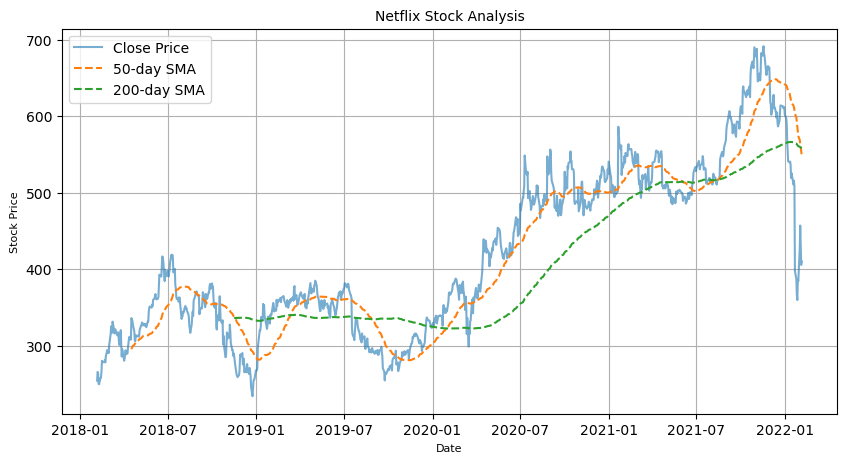

In [8]:
df["SMA_50"] = df["Close"].rolling(window=50).mean()  # Short-term trend
df["SMA_200"] = df["Close"].rolling(window=200).mean()  # Long-term trend

# Plot Trend
plt.figure(figsize=(10,5))

sns.lineplot(data=df, x=df["Date"], y="Close", label="Close Price", alpha=0.6)
sns.lineplot(data=df, x=df["Date"], y="SMA_50", label="50-day SMA", linestyle="--")
sns.lineplot(data=df, x=df["Date"], y="SMA_200", label="200-day SMA", linestyle="--")

plt.legend()
plt.title("Netflix Stock Analysis", fontsize=10)
plt.xlabel("Date", fontsize=8)
plt.ylabel("Stock Price", fontsize=8)
plt.grid(True)
plt.show()

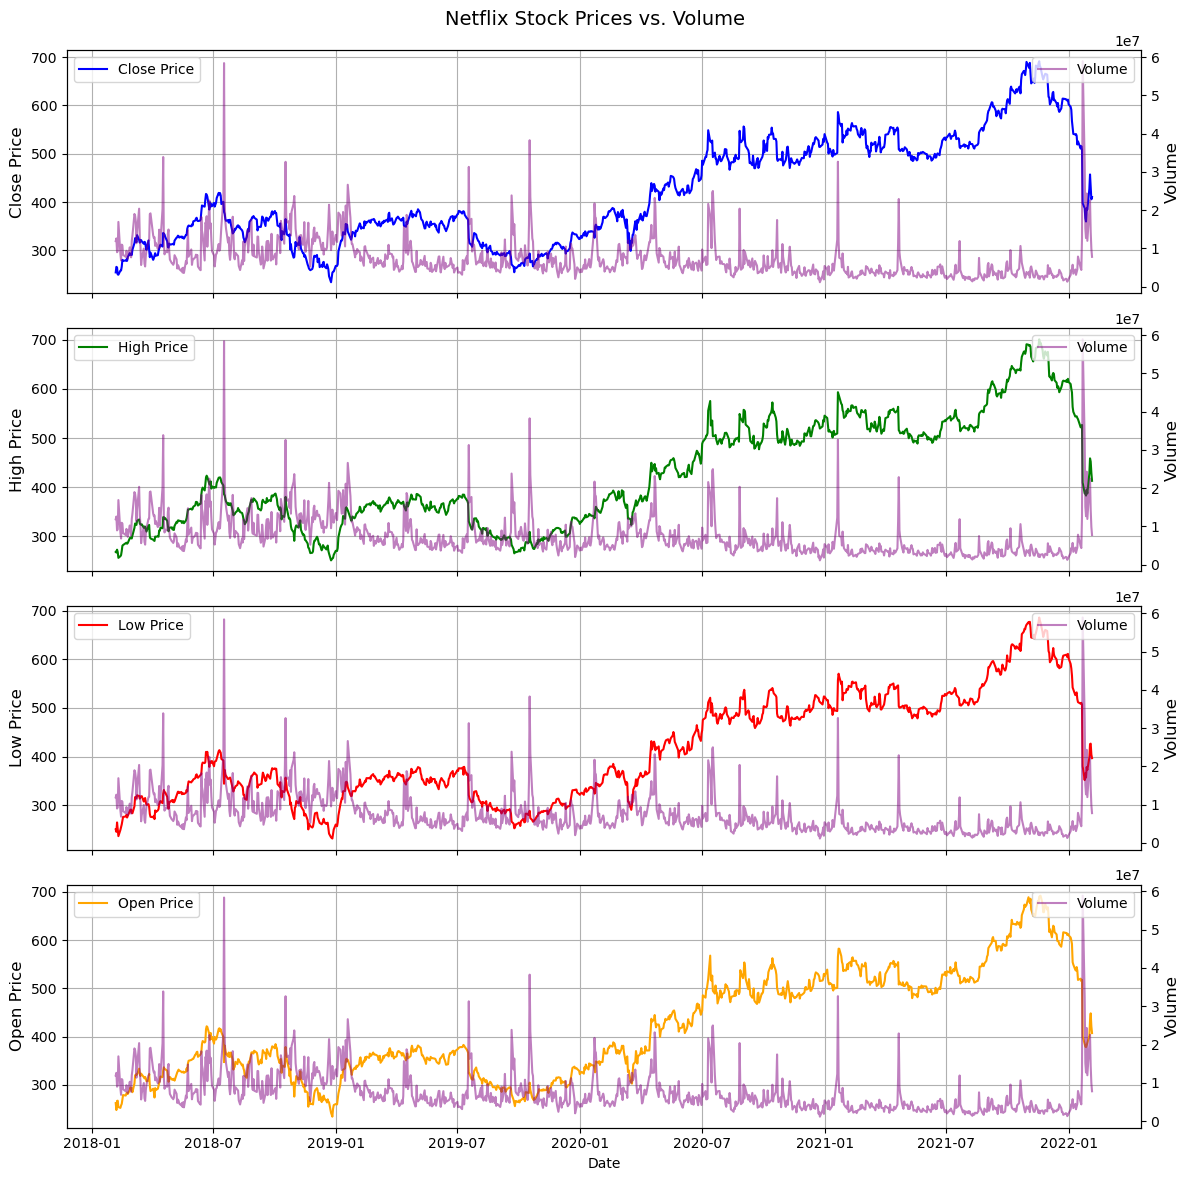

In [9]:
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)  # 4 rows 1 column and share x-axis

# Define colors for each subplot
colors = ["blue", "green", "red", "orange"]
features = ["Close", "High", "Low", "Open"]

# Loop through each feature and plot it against volume
for i, feature in enumerate(features):
    sns.lineplot(data=df, x="Date", y=feature, label=f"{feature} Price", color=colors[i], ax=axes[i])
    ax2 = axes[i].twinx()  # y-axis for volume feature
    sns.lineplot(data=df, x="Date", y="Volume", label="Volume", color="purple", ax=ax2, alpha=0.5)

    axes[i].set_ylabel(f"{feature} Price", fontsize=12)
    ax2.set_ylabel("Volume", fontsize=12)
    axes[i].legend(loc="upper left")
    ax2.legend(loc="upper right")
    axes[i].grid(True)

# Set labels
plt.xlabel("Date", fontsize=12)
plt.suptitle("Netflix Stock Prices vs. Volume", fontsize=14)

# show plots
plt.tight_layout()
plt.show()

From given plots we can derive the following:
- Close price increased from 2020 to 2022 while volume is increasing with spikes that indicates strong buying interest.
- regarding High Price in the same duration (2020 - 2022) it indicates investor strongly confident about buying.

In [10]:
#  Focusing on the duration between 2020 and 2022
net_2020_2022 = df[(df["Date"] >= "2020-01-01") | (df["Date"] >= "2022-12-31")]
net_2020_2022["Date"].max()

Timestamp('2022-02-04 00:00:00')

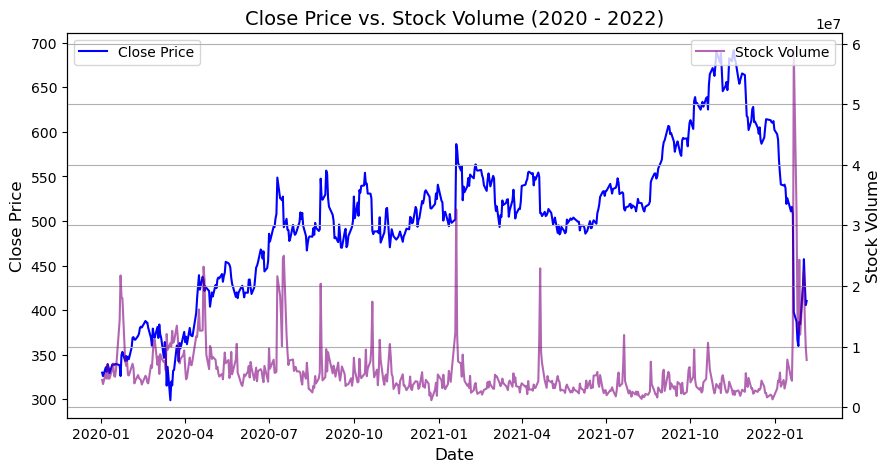

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 5))

sns.lineplot(data = net_2020_2022, x = "Date", y = "Close", label="Close Price", color="blue", ax=ax1)

ax1.set_ylabel("Close Price", fontsize=12)
ax1.set_xlabel("Date", fontsize=12)

ax2 = ax1.twinx()
sns.lineplot(data=net_2020_2022, x="Date", y = "Volume", label = "Stock Volume", color="purple", ax=ax2, alpha=0.6)
ax2.set_ylabel("Stock Volume", fontsize=12)

# Title and styling
ax1.set_title("Close Price vs. Stock Volume (2020 - 2022)", fontsize=14)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid(True)

# Show the plot
plt.show()

In [12]:
# Pearson Correlation between Close price and other features
corr = df.corr()
corr["Close"]

Date         0.841384
Open         0.996812
High         0.998551
Low          0.998544
Close        1.000000
Adj Close    1.000000
Volume      -0.413362
SMA_50       0.934207
SMA_200      0.855382
Name: Close, dtype: float64

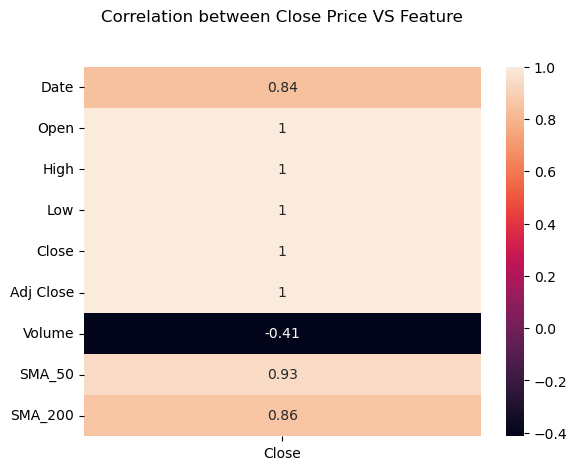

In [13]:
# Plotting Pearson Correlation using heatmap
g = sns.heatmap(corr[[df.columns[4]]], annot = True)
g.set_title("Correlation between Close Price VS Feature", y = 1.1)
plt.show()

# LSTM Model Structure

In [51]:
# Initialize LSTM model
def get_model(t, f):
    model = Sequential([
        Input(shape = (t, f)), # shape = (samples, time steps, features)
        LSTM(64, activation='tanh' ,return_sequences = False),  # to pass the full sequence to the input layer, tanh is used to handle continous values                      
        Dense(25, activation='relu'),
        Dense(1, activation = "sigmoid"), # return 1 output value, sigmoid been used because we scaled the data into [0, 1] range
    ])
    model.compile(optimizer="adam",
              loss='mean_squared_error',
              metrics=["mse"])
    
    return model

# Splitting data

We will use Close Price as Target variable to predict its value, features that will be the inputs for lstm model (Open, High, Low, Volume)

In [37]:
def split_sequences(sequences, n_steps):
    """
        it will take a dataset with rows for time steps and columns for parallel series
        and return input/output samples.

        Parameters:
        - sequences: NumPy array where rows represent time steps and columns represent features.
        - n_steps: Number of past time steps to use for predicting the next value.
    """
    X, y = list(), list()
    for i in range(len(sequences) - n_steps):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, [0, 1, 2, 4]], sequences[end_ix, 3] # order of cols ['Open', 'High', 'Low', 'Close', 'Volume']
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [38]:
# converting dataframe into numpy array
data_np = df.drop(columns=["Date", 'Adj Close', "SMA_50", "SMA_200"]).values # drop unrequired columns 
# confirming the conversion
type(data_np)

numpy.ndarray

In [39]:
scaler = MinMaxScaler()

# transform the entire dataset to avoid the lrge value of Volume feature that might affect the performance negativly
data_np_scaled = scaler.fit_transform(data_np)
data_np_scaled

array([[0.06125254, 0.03830439, 0.0413314 , 0.04451626, 0.18615035],
       [0.03005911, 0.03563978, 0.03027306, 0.06954849, 0.19826421],
       [0.07124314, 0.04840791, 0.07276962, 0.06701469, 0.13569008],
       ...,
       [0.46753051, 0.44706226, 0.42925296, 0.4272515 , 0.22856529],
       [0.4090483 , 0.39661149, 0.38044671, 0.37509011, 0.15168204],
       [0.3782257 , 0.35999466, 0.36365037, 0.38507243, 0.11493015]])

In [40]:
# definig the nsteps
n_steps = 2 # we will take 1 time step for each sequence
# splitting data
x, y = split_sequences(data_np_scaled, n_steps)
# summarize the data
for i in range(1):
	print(x[i], y[i])

[[0.06125254 0.03830439 0.0413314  0.18615035]
 [0.03005911 0.03563978 0.03027306 0.19826421]] 0.06701468557052936


In [41]:
print("X shape:", x.shape)  # (samples, n_steps per sequence, features or parallel time series)
print("y shape:", y.shape)  # (samples,)

X shape: (1007, 2, 4)
y shape: (1007,)


In [42]:
# storing number of features
n_features = x.shape[2]

# initialize the lstm model
model = get_model(n_steps, n_features)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - loss: 0.0560 - mse: 0.0560
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0301 - mse: 0.0301
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0042 - mse: 0.0042
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026 - mse: 0.0026
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0020 - mse: 0.0020
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0017 - mse: 0.0017
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018 - mse: 0.0018
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016 - mse: 0.0016
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - mse: 0.0016
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015 - mse: 0.0015
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - mse: 0.0016
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - mse: 0.0015
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━

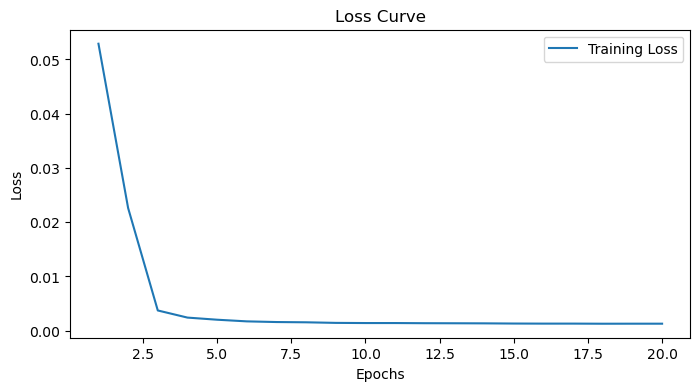

In [43]:
EPOCHS = 20 # we will train the model 20 time
BATCH_SIZE = 32
# Training phase
x = x.astype(np.float32) # convertin input data from object to float data type
y = y.astype(np.float32)

history = model.fit(x, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# Plotting line to determine the performance
history_dict = {
    "Epoch": range(1, len(history.history["loss"]) + 1),
    "Training Loss": history.history["loss"]
}
history_df = pd.DataFrame(history_dict)

# Plot Training Loss
plt.figure(figsize=(8, 4))
sns.lineplot(data=history_df, x="Epoch", y="Training Loss", label="Training Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [49]:
# Model performance on test data
new_data = np.array([[262.000000, 267.899994, 250.029999, 11896100]])  # [Open, High, Low, Volume]

# scaling the test data using the same scaler applied in training
new_data_scaled = scaler.transform(np.hstack([new_data, np.zeros((new_data.shape[0], 1))]))  # dummy Close column to match number of columns been used in scaling
new_data_scaled = np.delete(new_data_scaled, 3, axis=1)  # Remove Close column

# Ensure the correct number of time steps (n_steps = 2)
if new_data_scaled.shape[0] < n_steps:
    # Duplicate the row to match n_steps
    new_data_scaled = np.vstack([new_data_scaled] * n_steps)

# Reshape to match LSTM input (samples=1, time_steps=n_steps, features=4)
new_data_scaled = new_data_scaled.reshape(1, n_steps, 4)

In [50]:
# Predict the Close price (normalized)
predicted_close_scaled = model.predict(new_data_scaled)

# Convert back to the original value (scale inverse)
close_min = df["Close"].min()
close_max = df["Close"].max()
predicted_close_price = predicted_close_scaled * (close_max - close_min) + close_min

print("Predicted Close Price:", predicted_close_price[0, 0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
Predicted Close Price: 285.78986
